<a href="https://colab.research.google.com/github/ishumann/Coding-Implementation/blob/main/Transfer_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
 ! pip install -q kaggle


In [8]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imprime","key":"ca9360fba8beabaa892bb7075b2dc89a"}'}

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:

!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:50<00:00, 23.5MB/s]
100% 1.06G/1.06G [00:50<00:00, 22.8MB/s]


In [12]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/dogs-vs-cats.zip' mode='r'>>

In [13]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [14]:
# making a VGG16 object

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
conv_base.trainable = False

In [19]:
#generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/train",
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/test",
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [20]:
# normalize
def process(image, label):
    image = tensorflow.cast(image/255., tensorflow.float32)
    return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)


In [21]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [22]:
history = model.fit(train_ds, epochs = 10, validation_data=val_ds)

Epoch 1/10
625/625 [==============================] - 73s 105ms/step - loss: 0.2698 - accuracy: 0.8873 - val_loss: 0.2197 - val_accuracy: 0.9070
Epoch 2/10
625/625 [==============================] - 59s 93ms/step - loss: 0.1928 - accuracy: 0.9201 - val_loss: 0.2058 - val_accuracy: 0.9138
Epoch 3/10
625/625 [==============================] - 57s 91ms/step - loss: 0.1542 - accuracy: 0.9378 - val_loss: 0.2230 - val_accuracy: 0.9104
Epoch 4/10
625/625 [==============================] - 66s 106ms/step - loss: 0.1280 - accuracy: 0.9488 - val_loss: 0.2137 - val_accuracy: 0.9166
Epoch 5/10
625/625 [==============================] - 59s 94ms/step - loss: 0.1013 - accuracy: 0.9609 - val_loss: 0.2290 - val_accuracy: 0.9142
Epoch 6/10
625/625 [==============================] - 57s 91ms/step - loss: 0.0748 - accuracy: 0.9725 - val_loss: 0.2477 - val_accuracy: 0.9164
Epoch 7/10
625/625 [==============================] - 57s 92ms/step - loss: 0.0500 - accuracy: 0.9833 - val_loss: 0.2855 - val_accurac

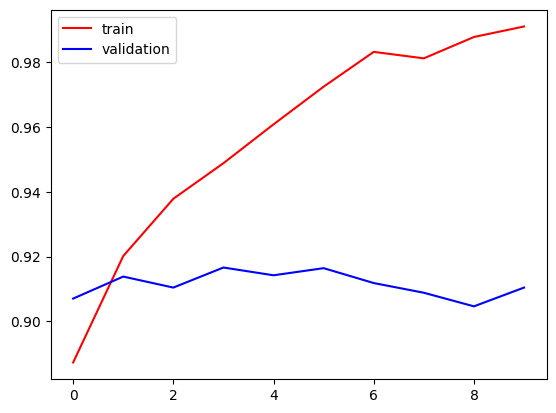

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

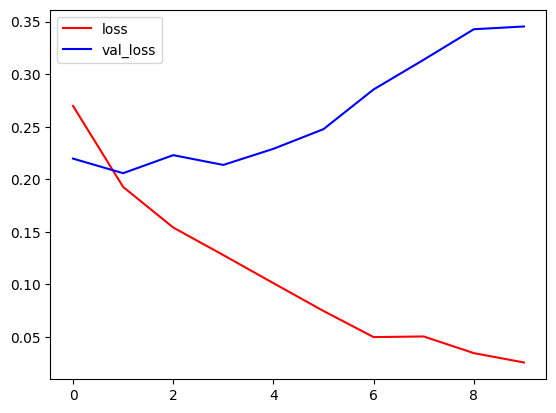

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
plt.legend()
plt.show()

## Implementing Augumentation

In [27]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img

In [31]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range= 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/train/',
    target_size= (150,150),
    batch_size= batch_size,
    class_mode = 'binary'
)

val_generator = test_datagen.flow_from_directory(
    '/content/test/',
    target_size= (150,150),
    batch_size= batch_size,
    class_mode = 'binary'
)



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [32]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [38]:
history =model.fit_generator(train_generator, epochs= 2, validation_data=val_generator)

<ipython-input-38-e00012e50be3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history =model.fit_generator(train_generator, epochs= 2, validation_data=val_generator)


Epoch 1/2
625/625 [==============================] - 164s 263ms/step - loss: 0.1496 - accuracy: 0.9387 - val_loss: 0.2091 - val_accuracy: 0.9150
Epoch 2/2
625/625 [==============================] - 165s 265ms/step - loss: 0.1426 - accuracy: 0.9398 - val_loss: 0.2125 - val_accuracy: 0.9170


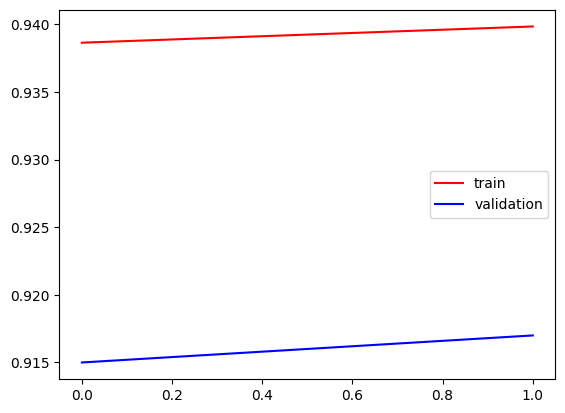

In [39]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

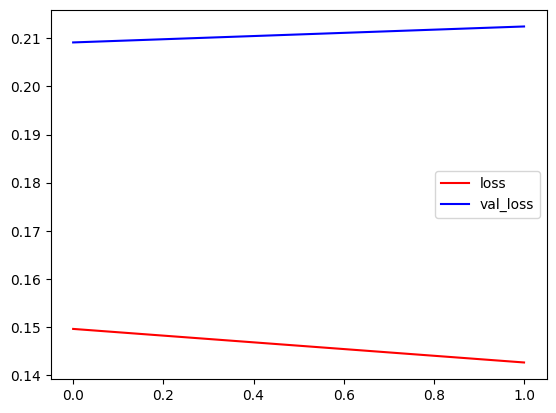

In [40]:
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
plt.legend()
plt.show()